<a href="https://colab.research.google.com/github/DarshanaRamroop/python_project/blob/master/creditscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   A0  A1  A2      A3  A4  A5  A6  A7  A8  A9  ...  A36  A37  A38  A39  A40  \
0   1   4  31  Female   5   3   1   3   0   1  ...    0    4    0    0    0   
1   2   4  31  Female   5   3   1   3   0   1  ...    0    2    0    0    0   
2   3   3  26  Female   7   3   1   0   0   1  ...    0    7    0  104    0   
3   4   0  63    Male   7   3   3   2   0   2  ...    0    3    0    0    0   
4   5   0  26    Male   5   3   1   1   0   1  ...    1    0    0    0    0   

   A41  A42  A43  A44       A45  
0    0    0    0    0  28553.30  
1    0    0    0    0  10410.00  
2    0    0    0    0  10979.06  
3    0    0    0    0  10242.00  
4    0    0    0  200   1489.00  

[5 rows x 46 columns]
A0     0
A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
A17    0
A18    0
A19    0
A20    0
A21    0
A22    0
A23    0
A24    0
A25    0
A26    0
A27    0
A28    0
A29    0
A30    0
A31    0
A32    0
A

,Metric,Score
0,Accuracy,0.675400
1,Precision,0.401600
2,Recall,0.776800
3,F1-Score,0.529500


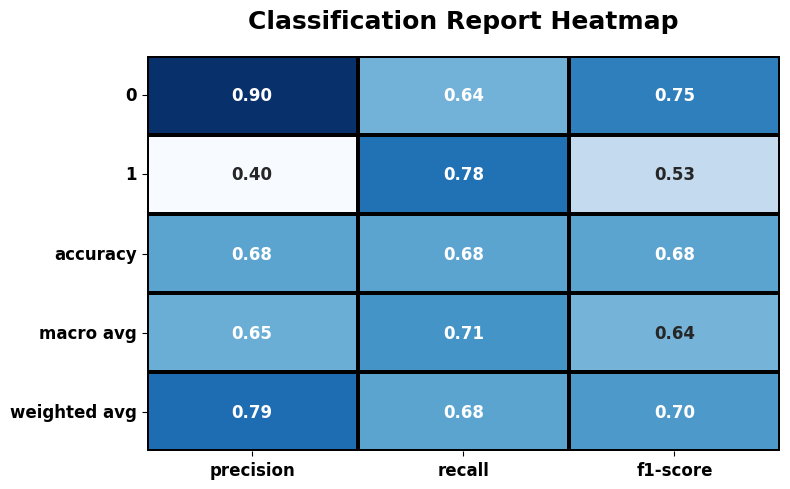

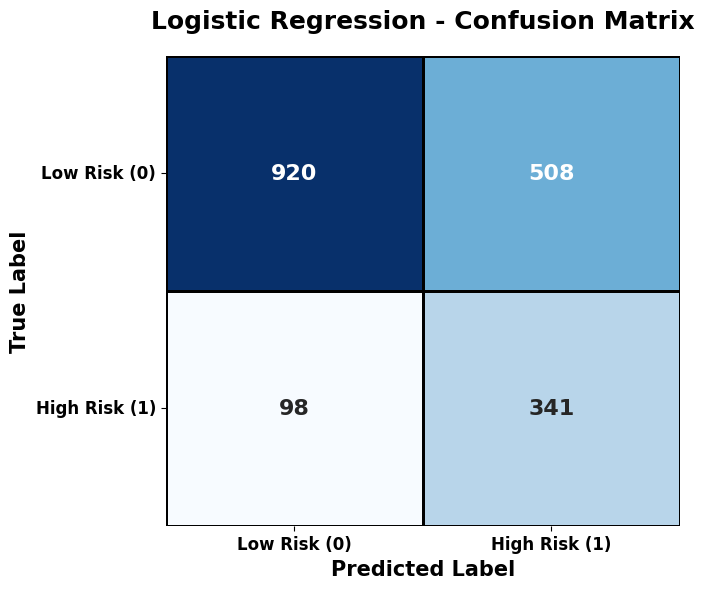

/tmp/ipython-input-2-1170597755.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(lr_metrics.keys()), y=list(lr_metrics.values()), palette='Blues', edgecolor='black')


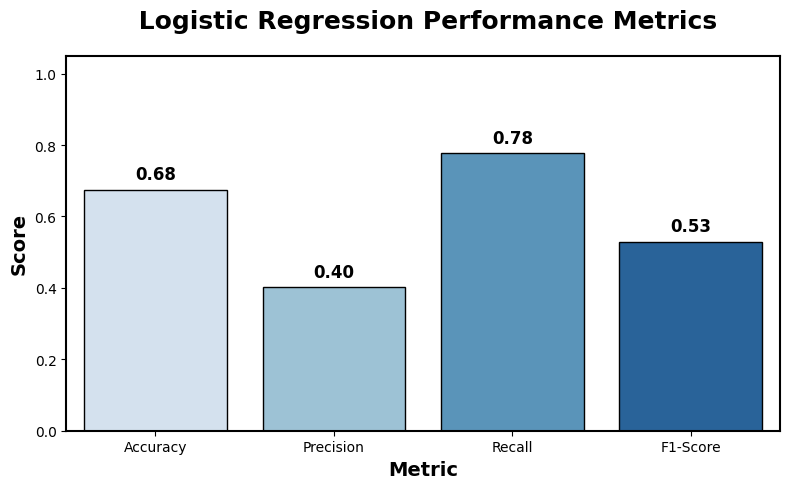

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from IPython.display import display

#load dataset
df = pd.read_csv('/content/creditscore_anon_cw_july2023.csv')

#display the first 5 rows of the dataset
print(df.head())

#check for missing values in each column
print(df.isnull().sum())

#handle outliers
for col in ['A14', 'A39', 'A45']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

#separate features and target variable
X = df.drop(['A0', 'A1'], axis=1)

#one-hot encode
X_encoded = pd.get_dummies(X, columns=['A3', 'A4', 'A17', 'A20'], drop_first=True)

#standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

#convert target into binary classification (0 = low risk, 1 = high risk)
y_binary = df['A1'].apply(lambda x: 1 if x >= 3 else 0)

#stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#create hyperparameter grid
lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced', None],
    'max_iter': [1000]
}

#use gridSearchCV for tuning
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#fit the model
lr_grid.fit(X_scaled, y_binary)

#retrieve the best estimator from GridSearch
lr_best = lr_grid.best_estimator_

#make prediciton
y_pred_lr_best = cross_val_predict(lr_best, X_scaled, y_binary, cv=skf)

#performance metrics
lr_metrics = {
    'Accuracy': accuracy_score(y_binary, y_pred_lr_best),
    'Precision': precision_score(y_binary, y_pred_lr_best, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_lr_best, zero_division=0),
    'F1-Score': f1_score(y_binary, y_pred_lr_best, zero_division=0)
}

#convert metrics into a DataFrame
lr_metrics_df = pd.DataFrame(lr_metrics.items(), columns=['Metric', 'Score']).round(4)

#styling of the performance metric
styled_table = lr_metrics_df.style \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#001f3f'),
            ('color', '#FFD700'),
            ('font-weight', 'bold'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border-bottom', '2px solid #FFD700')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f8f9fa'),
            ('color', '#001f3f'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '13pt'),
            ('text-align', 'center'),
            ('border-bottom', '1px solid #ddd')
        ]},
        {'selector': 'tbody tr:hover', 'props': [
            ('background-color', '#e0e6f8'),
        ]}
    ]) \
    .set_caption("📊 Logistic Regression Metrics Summary") \
    .highlight_max(color='#28a745')   \
    .highlight_min(color='#dc3545')

display(styled_table)

#generate classification
report_dict = classification_report(y_binary, y_pred_lr_best, zero_division=0, output_dict=True)

#convert classification into dataframe
report_df = pd.DataFrame(report_dict).transpose().round(3)
metrics_heatmap = report_df.drop(columns='support', errors='ignore')

#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    metrics_heatmap,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=False,
    linewidths=1.5,
    linecolor='black',
    annot_kws={"size": 12, "weight": "bold"}
)

plt.title('Classification Report Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tight_layout()
plt.show()

#confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix(y_binary, y_pred_lr_best),
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=2,
    linecolor='black',
    cbar=False,
    annot_kws={"size": 16, "weight": "bold"}
)
plt.title('Logistic Regression - Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, weight='bold')
plt.ylabel('True Label', fontsize=15, weight='bold')
plt.xticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold')
plt.yticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#bat plot for performance metric
plt.figure(figsize=(8, 5))
sns.barplot(x=list(lr_metrics.keys()), y=list(lr_metrics.values()), palette='Blues', edgecolor='black')
plt.ylim(0, 1.05)
plt.title(' Logistic Regression Performance Metrics', fontsize=18, weight='bold', pad=20)
plt.ylabel('Score', fontsize=14, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
for i, v in enumerate(lr_metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12, weight='bold')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 90 candidates, totalling 450 fits


,Metric,Score
0,Accuracy,0.607900
1,Precision,0.360900
2,Recall,0.865600
3,F1-Score,0.509400


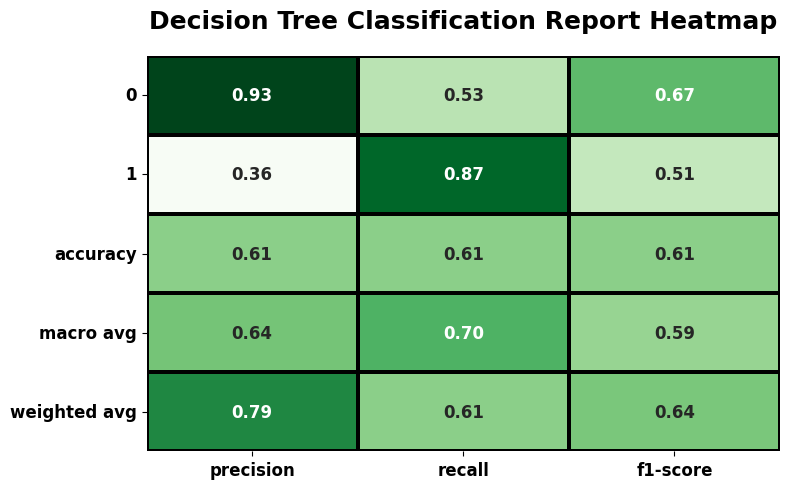

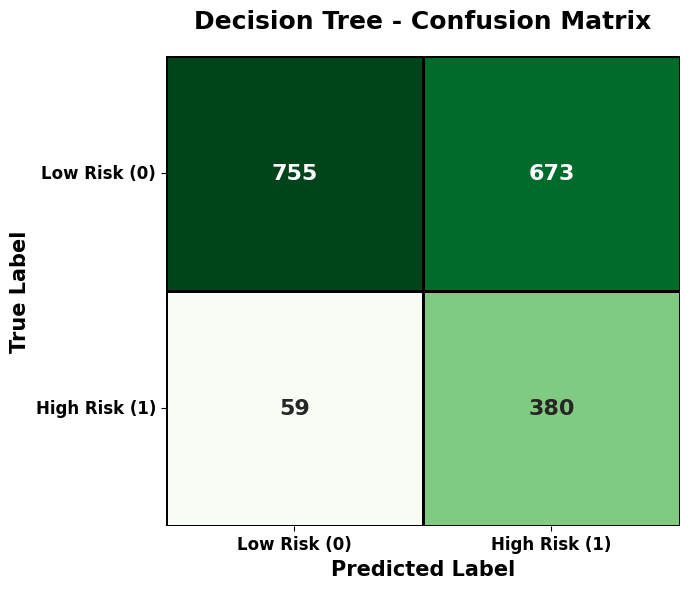

/tmp/ipython-input-2-2023213327.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dt_metrics.keys()), y=list(dt_metrics.values()), palette='Greens', edgecolor='black')


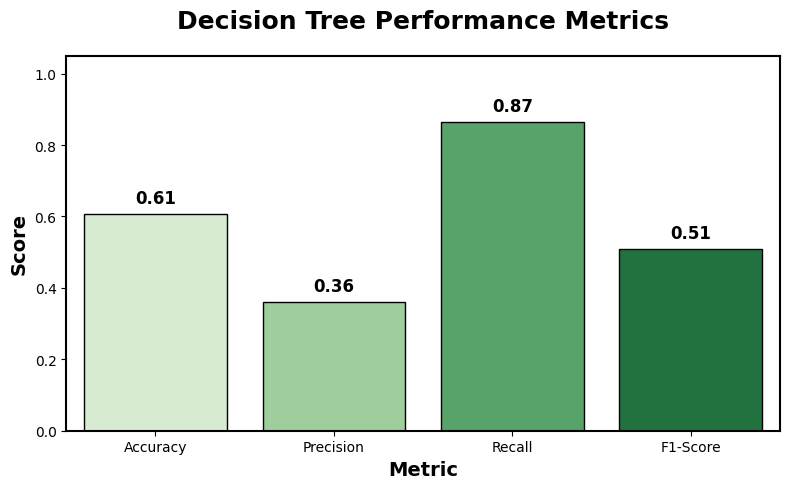

In [ ]:
#create hyperparameter grid
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

#use of Grid Search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#fit the model
dt_grid.fit(X_scaled, y_binary)
dt_best = dt_grid.best_estimator_

#make prediction
y_pred_dt_best = cross_val_predict(dt_best, X_scaled, y_binary, cv=skf)

#performance metric
dt_metrics = {
    'Accuracy': accuracy_score(y_binary, y_pred_dt_best),
    'Precision': precision_score(y_binary, y_pred_dt_best, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_dt_best, zero_division=0),
    'F1-Score': f1_score(y_binary, y_pred_dt_best, zero_division=0)
}

#convert into DataFrame
dt_metrics_df = pd.DataFrame(dt_metrics.items(), columns=['Metric', 'Score']).round(4)

#style the performance metric table
styled_dt_table = dt_metrics_df.style \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#001f3f'),
            ('color', '#FFD700'),
            ('font-weight', 'bold'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border-bottom', '2px solid #FFD700')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f8f9fa'),
            ('color', '#001f3f'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '13pt'),
            ('text-align', 'center'),
            ('border-bottom', '1px solid #ddd')
        ]},
        {'selector': 'tbody tr:hover', 'props': [
            ('background-color', '#e0e6f8'),
        ]}
    ]) \
    .set_caption("📊 Decision Tree Metrics Summary") \
    .highlight_max(color='#28a745') \
    .highlight_min(color='#dc3545')

display(styled_dt_table)

#generate classification
dt_report_dict = classification_report(y_binary, y_pred_dt_best, zero_division=0, output_dict=True)

#covert into dataframe
dt_report_df = pd.DataFrame(dt_report_dict).transpose().round(3)

#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    dt_report_df.drop(columns='support', errors='ignore'),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar=False,
    linewidths=1.5,
    linecolor='black',
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title('Decision Tree Classification Report Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix(y_binary, y_pred_dt_best),
    annot=True,
    fmt='d',
    cmap='Greens',
    linewidths=2,
    linecolor='black',
    cbar=False,
    annot_kws={"size": 16, "weight": "bold"}
)
plt.title('Decision Tree - Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, weight='bold')
plt.ylabel('True Label', fontsize=15, weight='bold')
plt.xticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold')
plt.yticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#plot bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(dt_metrics.keys()), y=list(dt_metrics.values()), palette='Greens', edgecolor='black')
plt.ylim(0, 1.05)
plt.title('Decision Tree Performance Metrics', fontsize=18, weight='bold', pad=20)
plt.ylabel('Score', fontsize=14, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
for i, v in enumerate(dt_metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12, weight='bold')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,Metric,Score
0,Accuracy,0.682400
1,Precision,0.405400
2,Recall,0.751700
3,F1-Score,0.526700


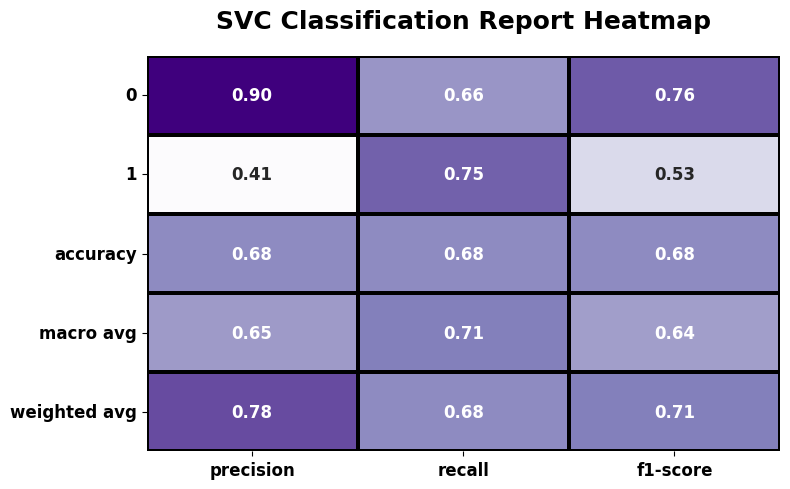

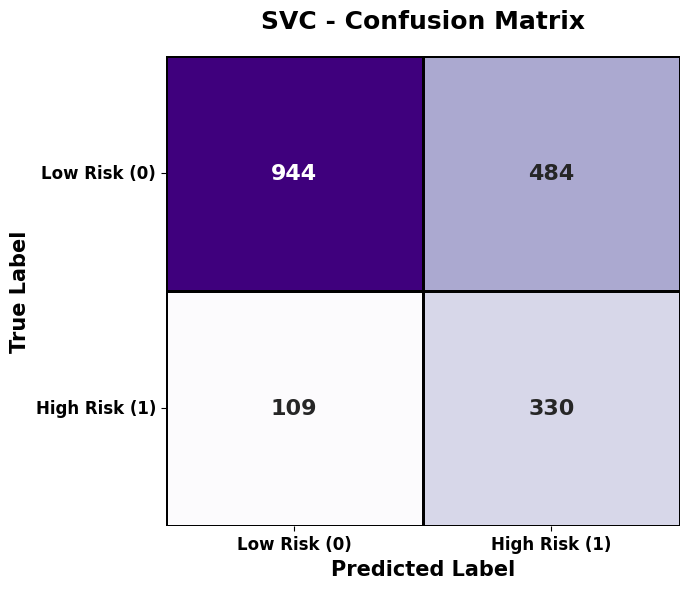

/tmp/ipython-input-3-1194056931.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(svc_metrics.keys()), y=list(svc_metrics.values()), palette='Purples', edgecolor='black')


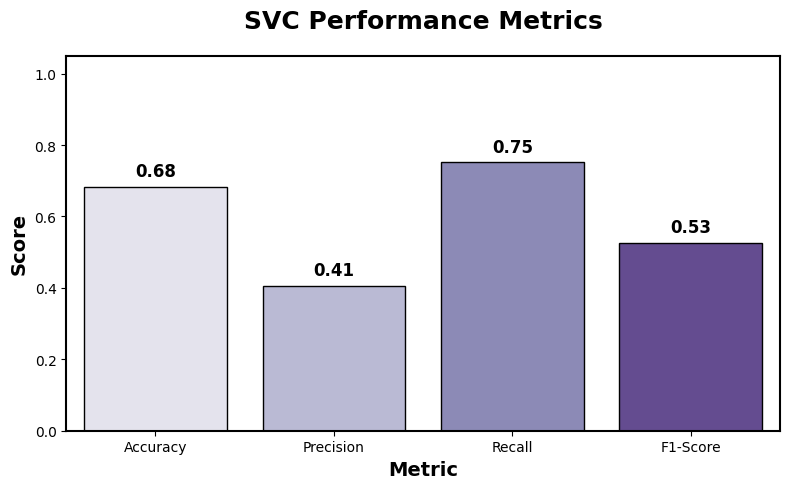

In [ ]:
#create hyperparameter grid
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]
}

#use grid search
svc_grid = GridSearchCV(
    SVC(random_state=42),
    svc_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#fit model
svc_grid.fit(X_scaled, y_binary)
svc_best = svc_grid.best_estimator_

#make prediction
y_pred_svc_best = cross_val_predict(svc_best, X_scaled, y_binary, cv=skf)

#performance metric
svc_metrics = {
    'Accuracy': accuracy_score(y_binary, y_pred_svc_best),
    'Precision': precision_score(y_binary, y_pred_svc_best, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_svc_best, zero_division=0),
    'F1-Score': f1_score(y_binary, y_pred_svc_best, zero_division=0)
}

#convert into DataFrame
svc_metrics_df = pd.DataFrame(svc_metrics.items(), columns=['Metric', 'Score']).round(4)

#style the table
styled_svc_table = svc_metrics_df.style \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#001f3f'),
            ('color', '#FFD700'),
            ('font-weight', 'bold'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border-bottom', '2px solid #FFD700')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f8f9fa'),
            ('color', '#001f3f'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '13pt'),
            ('text-align', 'center'),
            ('border-bottom', '1px solid #ddd')
        ]},
        {'selector': 'tbody tr:hover', 'props': [
            ('background-color', '#e0e6f8'),
        ]}
    ]) \
    .set_caption("📊 SVC Metrics Summary") \
    .highlight_max(color='#28a745') \
    .highlight_min(color='#dc3545')

display(styled_svc_table)

#generate classification
svc_report_dict = classification_report(y_binary, y_pred_svc_best, zero_division=0, output_dict=True)
svc_report_df = pd.DataFrame(svc_report_dict).transpose().round(3)

#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    svc_report_df.drop(columns='support', errors='ignore'),
    annot=True,
    fmt=".2f",
    cmap="Purples",
    cbar=False,
    linewidths=1.5,
    linecolor='black',
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title('SVC Classification Report Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix(y_binary, y_pred_svc_best),
    annot=True,
    fmt='d',
    cmap='Purples',
    linewidths=2,
    linecolor='black',
    cbar=False,
    annot_kws={"size": 16, "weight": "bold"}
)
plt.title('SVC - Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, weight='bold')
plt.ylabel('True Label', fontsize=15, weight='bold')
plt.xticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold')
plt.yticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#bar plot for performance metric
plt.figure(figsize=(8, 5))
sns.barplot(x=list(svc_metrics.keys()), y=list(svc_metrics.values()), palette='Purples', edgecolor='black')
plt.ylim(0, 1.05)
plt.title('SVC Performance Metrics', fontsize=18, weight='bold', pad=20)
plt.ylabel('Score', fontsize=14, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
for i, v in enumerate(svc_metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12, weight='bold')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,Metric,Score
0,Accuracy,0.678600
1,Precision,0.406700
2,Recall,0.799500
3,F1-Score,0.539200


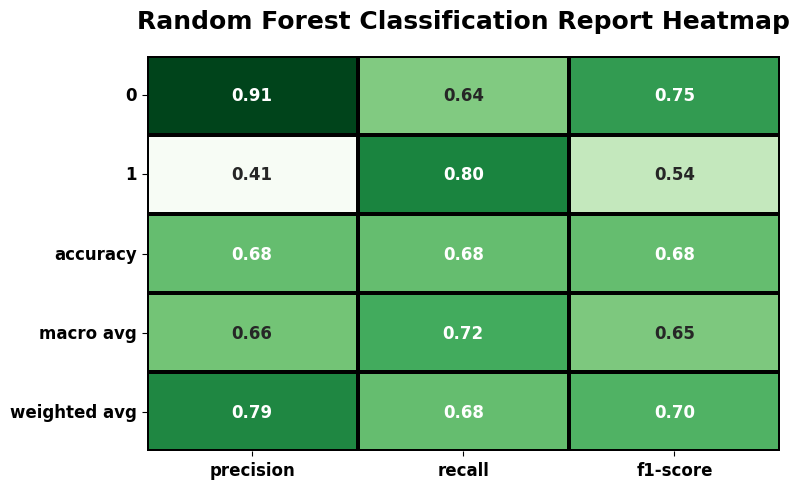

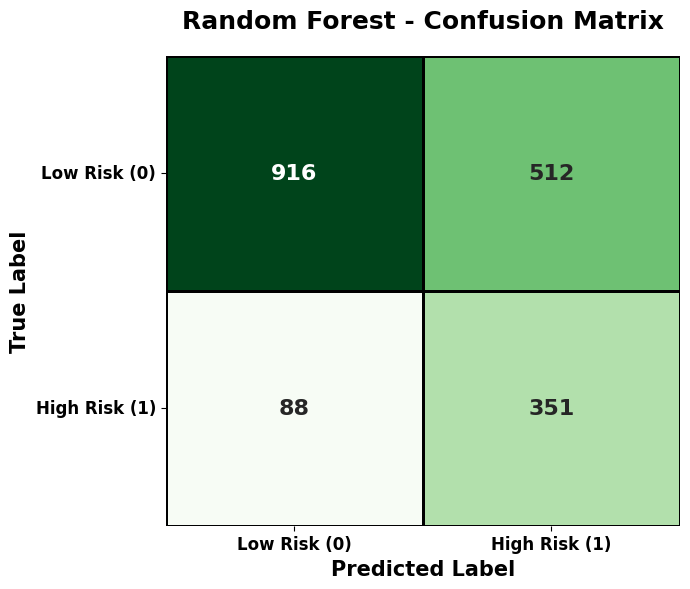

/tmp/ipython-input-4-4122901830.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(rf_metrics.keys()), y=list(rf_metrics.values()), palette='Greens', edgecolor='black')


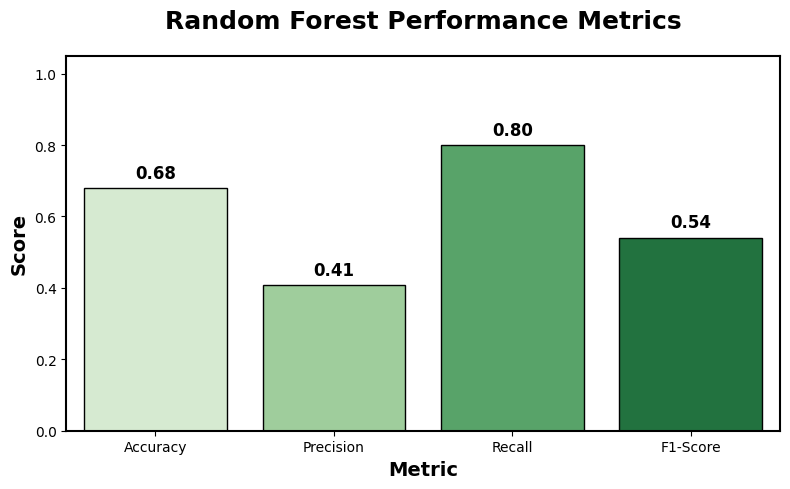

In [ ]:
#create hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

#use of grid search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#fit model
rf_grid.fit(X_scaled, y_binary)
rf_best = rf_grid.best_estimator_

#make prediction
y_pred_rf_best = cross_val_predict(rf_best, X_scaled, y_binary, cv=skf)

#performance metric
rf_metrics = {
    'Accuracy': accuracy_score(y_binary, y_pred_rf_best),
    'Precision': precision_score(y_binary, y_pred_rf_best, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_rf_best, zero_division=0),
    'F1-Score': f1_score(y_binary, y_pred_rf_best, zero_division=0)
}

rf_metrics_df = pd.DataFrame(rf_metrics.items(), columns=['Metric', 'Score']).round(4)

#stlying of the table
styled_rf_table = rf_metrics_df.style \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#001f3f'),
            ('color', '#FFD700'),
            ('font-weight', 'bold'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border-bottom', '2px solid #FFD700')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f8f9fa'),
            ('color', '#001f3f'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '13pt'),
            ('text-align', 'center'),
            ('border-bottom', '1px solid #ddd')
        ]},
        {'selector': 'tbody tr:hover', 'props': [
            ('background-color', '#e0e6f8'),
        ]}
    ]) \
    .set_caption("📊 Random Forest Metrics Summary") \
    .highlight_max(color='#28a745') \
    .highlight_min(color='#dc3545')

display(styled_rf_table)

#create classification
rf_report_dict = classification_report(y_binary, y_pred_rf_best, zero_division=0, output_dict=True)
rf_report_df = pd.DataFrame(rf_report_dict).transpose().round(3)

#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    rf_report_df.drop(columns='support', errors='ignore'),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    cbar=False,
    linewidths=1.5,
    linecolor='black',
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title('Random Forest Classification Report Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix(y_binary, y_pred_rf_best),
    annot=True,
    fmt='d',
    cmap='Greens',
    linewidths=2,
    linecolor='black',
    cbar=False,
    annot_kws={"size": 16, "weight": "bold"}
)
plt.title('Random Forest - Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, weight='bold')
plt.ylabel('True Label', fontsize=15, weight='bold')
plt.xticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold')
plt.yticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#performance metric
plt.figure(figsize=(8, 5))
sns.barplot(x=list(rf_metrics.keys()), y=list(rf_metrics.values()), palette='Greens', edgecolor='black')
plt.ylim(0, 1.05)
plt.title('Random Forest Performance Metrics', fontsize=18, weight='bold', pad=20)
plt.ylabel('Score', fontsize=14, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
for i, v in enumerate(rf_metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12, weight='bold')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,Metric,Score
0,Accuracy,0.771800
1,Precision,0.521500
2,Recall,0.359900
3,F1-Score,0.425900


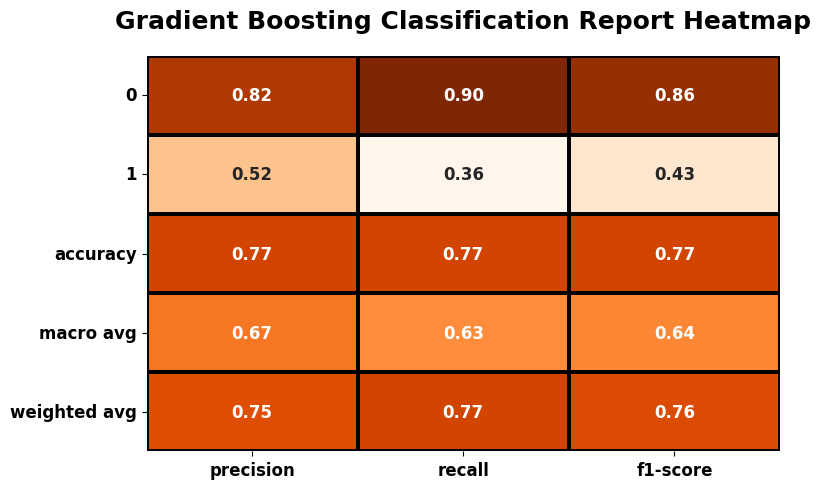

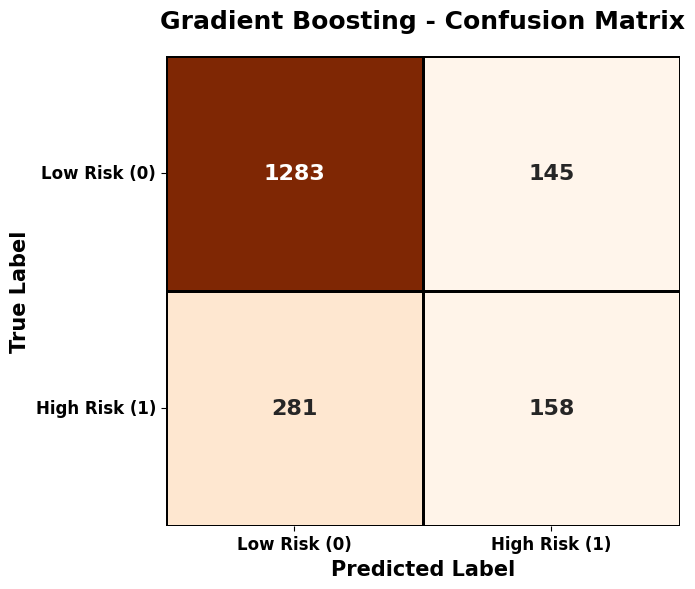

/tmp/ipython-input-5-4096565735.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(gb_metrics.keys()), y=list(gb_metrics.values()), palette='Oranges', edgecolor='black')


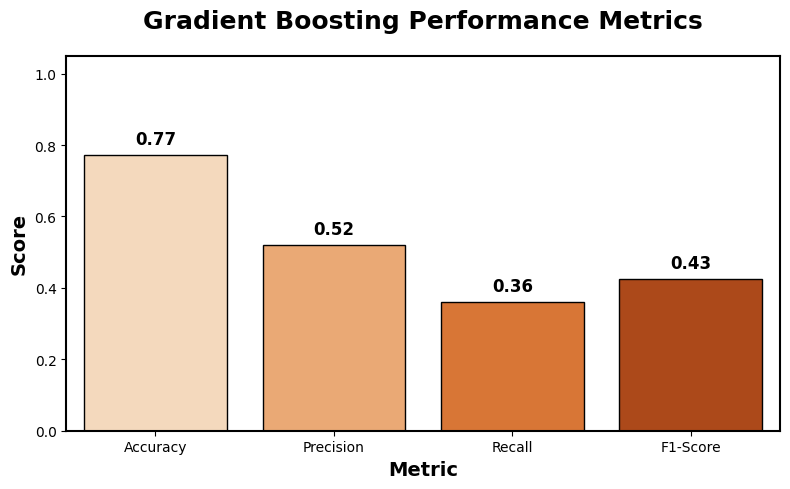

In [ ]:
#create hyperparameter grid
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

#use of GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#fit model
gb_grid.fit(X_scaled, y_binary)
gb_best = gb_grid.best_estimator_

#make prediction
y_pred_gb_best = cross_val_predict(gb_best, X_scaled, y_binary, cv=skf)

#performance metric
gb_metrics = {
    'Accuracy': accuracy_score(y_binary, y_pred_gb_best),
    'Precision': precision_score(y_binary, y_pred_gb_best, zero_division=0),
    'Recall': recall_score(y_binary, y_pred_gb_best, zero_division=0),
    'F1-Score': f1_score(y_binary, y_pred_gb_best, zero_division=0)
}
gb_metrics_df = pd.DataFrame(gb_metrics.items(), columns=['Metric', 'Score']).round(4)

#styling for the table
styled_gb_table = gb_metrics_df.style \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#001f3f'),
            ('color', '#FFD700'),
            ('font-weight', 'bold'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border-bottom', '2px solid #FFD700')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f8f9fa'),
            ('color', '#001f3f'),
            ('font-family', 'Calibri, sans-serif'),
            ('font-size', '13pt'),
            ('text-align', 'center'),
            ('border-bottom', '1px solid #ddd')
        ]},
        {'selector': 'tbody tr:hover', 'props': [
            ('background-color', '#e0e6f8'),
        ]}
    ]) \
    .set_caption("📊 Gradient Boosting Metrics Summary") \
    .highlight_max(color='#28a745') \
    .highlight_min(color='#dc3545')

display(styled_gb_table)

#create classification
gb_report_dict = classification_report(y_binary, y_pred_gb_best, zero_division=0, output_dict=True)
gb_report_df = pd.DataFrame(gb_report_dict).transpose().round(3)

#plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    gb_report_df.drop(columns='support', errors='ignore'),
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    cbar=False,
    linewidths=1.5,
    linecolor='black',
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title('Gradient Boosting Classification Report Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix(y_binary, y_pred_gb_best),
    annot=True,
    fmt='d',
    cmap='Oranges',
    linewidths=2,
    linecolor='black',
    cbar=False,
    annot_kws={"size": 16, "weight": "bold"}
)
plt.title('Gradient Boosting - Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, weight='bold')
plt.ylabel('True Label', fontsize=15, weight='bold')
plt.xticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold')
plt.yticks([0.5, 1.5], ['Low Risk (0)', 'High Risk (1)'], fontsize=12, weight='bold', rotation=0)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

#bar plot for performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(gb_metrics.keys()), y=list(gb_metrics.values()), palette='Oranges', edgecolor='black')
plt.ylim(0, 1.05)
plt.title('Gradient Boosting Performance Metrics', fontsize=18, weight='bold', pad=20)
plt.ylabel('Score', fontsize=14, weight='bold')
plt.xlabel('Metric', fontsize=14, weight='bold')
for i, v in enumerate(gb_metrics.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', fontsize=12, weight='bold')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')
plt.tight_layout()
plt.show()

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.679,0.407,0.800,0.539
1,Logistic Regression,0.675,0.402,0.777,0.530
2,SVC,0.682,0.405,0.752,0.527
3,Decision Tree,0.608,0.361,0.866,0.509
4,Gradient Boosting,0.772,0.521,0.360,0.426


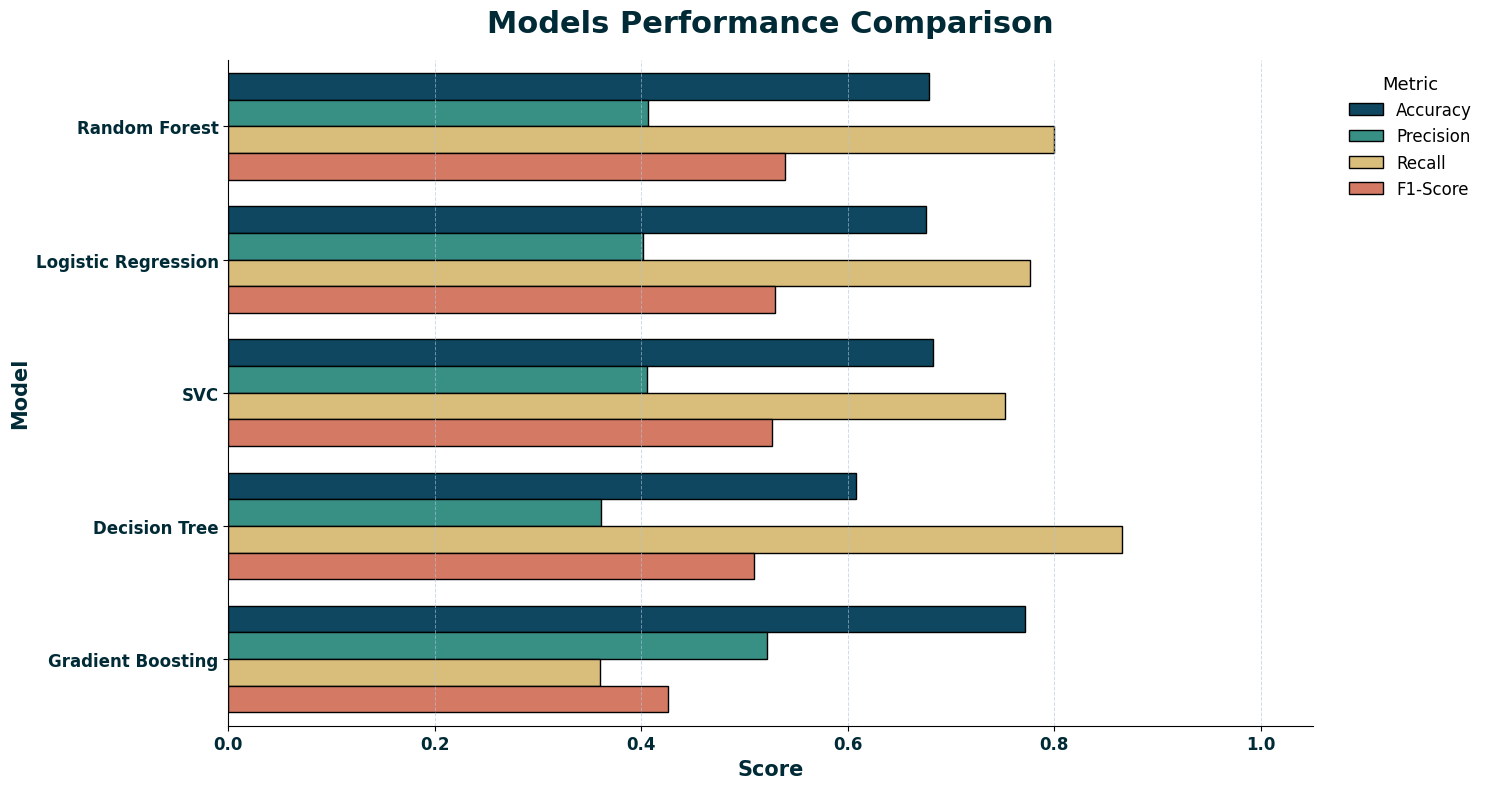

In [ ]:
tuned_metrics = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Accuracy': lr_metrics['Accuracy'], 'Precision': lr_metrics['Precision'], 'Recall': lr_metrics['Recall'], 'F1-Score': lr_metrics['F1-Score']},
    {'Model': 'Decision Tree', 'Accuracy': dt_metrics['Accuracy'], 'Precision': dt_metrics['Precision'], 'Recall': dt_metrics['Recall'], 'F1-Score': dt_metrics['F1-Score']},
    {'Model': 'SVC', 'Accuracy': svc_metrics['Accuracy'], 'Precision': svc_metrics['Precision'], 'Recall': svc_metrics['Recall'], 'F1-Score': svc_metrics['F1-Score']},
    {'Model': 'Random Forest', 'Accuracy': rf_metrics['Accuracy'], 'Precision': rf_metrics['Precision'], 'Recall': rf_metrics['Recall'], 'F1-Score': rf_metrics['F1-Score']},
    {'Model': 'Gradient Boosting', 'Accuracy': gb_metrics['Accuracy'], 'Precision': gb_metrics['Precision'], 'Recall': gb_metrics['Recall'], 'F1-Score': gb_metrics['F1-Score']}
])

tuned_metrics_sorted = tuned_metrics.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

#styling
styled_finance = (
    tuned_metrics_sorted.style
    .format({'Accuracy': '{:.3f}', 'Precision': '{:.3f}', 'Recall': '{:.3f}', 'F1-Score': '{:.3f}'})
    .set_caption("📊 Models Performance Summary")
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', '#002b36'), ('font-size', '18pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#002b36'), ('color', '#FFD700'), ('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '11pt'), ('text-align', 'center'), ('border-bottom', '1px solid #ccc')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f0f5f9')]}
    ])
    .highlight_max(axis=0, color='#28a745')
    .highlight_min(axis=0, color='#dc3545')
)

display(styled_finance)

metrics_melted = tuned_metrics_sorted.melt(id_vars='Model', var_name='Metric', value_name='Score')


finance_palette = {
    'Accuracy': '#004c6d',
    'Precision': '#2a9d8f',
    'Recall': '#e9c46a',
    'F1-Score': '#e76f51'
}

#plot bar plot
plt.figure(figsize=(15, 8))
sns.barplot(
    data=metrics_melted,
    x='Score', y='Model', hue='Metric',
    palette=finance_palette,
    edgecolor='black'
)

plt.title('Models Performance Comparison', fontsize=22, weight='bold', color='#002b36', pad=20)
plt.xlabel('Score', fontsize=15, weight='bold', color='#002b36')
plt.ylabel('Model', fontsize=15, weight='bold', color='#002b36')
plt.xlim(0, 1.05)

#axis ticks style
plt.xticks(fontsize=12, weight='bold', color='#002b36')
plt.yticks(fontsize=12, weight='bold', color='#002b36')

plt.grid(axis='x', linestyle='--', linewidth=0.7, color='#b0c4de', alpha=0.6)

plt.legend(title='Metric', title_fontsize=13, fontsize=12, frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')
sns.despine()

plt.tight_layout()
plt.show()